In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

In [3]:
import random

import deeptrack as dt
import deeptrack.extras
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

deeptrack.extras.datasets.load("CellData")

Download Complete!
Extracting files...
Done
Cleaning up...
...OK!


In [4]:
import numpy as np
import matplotlib.pyplot as plt

crop_size = 64
padding = 32
wavelength = 633e-9 
pixel_size = 114e-9
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

experimental_data = np.load(r'datasets/CellData/shifted_cell_data.npy', allow_pickle=True)

In [49]:
np.shape(experimental_data)

(85, 675, 915, 2)

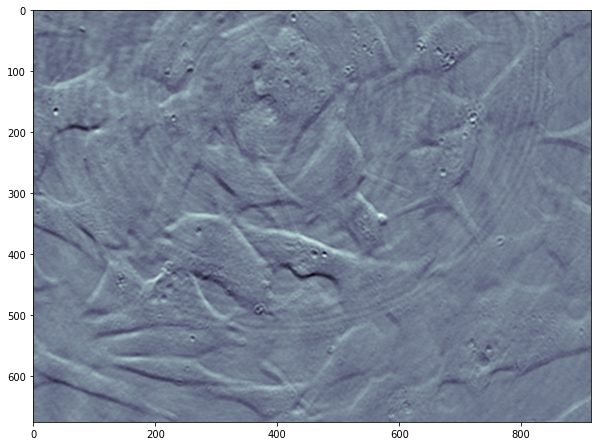

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(experimental_data[30, ..., 1], cmap="bone")

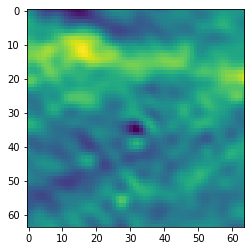

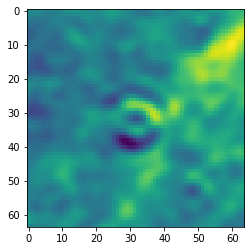

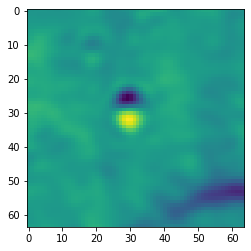

In [20]:
ds = 2
crs = 64

crops = [
    (30, 400, 537),
    (10, (1070 - 32) // 2, (950 - 32) // 2 ),
    (0, (310 - 32) // 2, (40 - 32) // 2),
    
]

training_images = []

for t, x, y in crops:
    im = experimental_data[t, x:x+crs, y:y+crs]
    training_images.append(im)
    plt.imshow(im[..., 1])
    plt.show()


In [21]:
args = dt.Arguments(
    translate=lambda: np.random.randn(2) * 1,
    rotate=lambda:np.random.uniform(0, np.pi*2),
    z=lambda: np.random.uniform(-3, 3),
    rescale=lambda: 10**np.random.uniform(-0.8, 0.8)
)

group = ( 
     dt.Affine(rotate=args.rotate) 
    >>dt.Affine(translate=args.translate) 
    >> dt.Rescale(args.rescale) 
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
    >> dt.Add(lambda: np.random.randn(1, 1, 2) * 0.05)
)
group = group[8:-8, 8:-8]

equivariance = (
    dt.models.autotracking.TranslationalEquivariance(args.translate)
    >> dt.models.autotracking.Rotational2DEquivariance(args.rotate)
    # >> dt.models.autotracking.Equivariance(1, args.z / 10, indexes=2)
    >> dt.models.autotracking.Equivariance(1, lambda arg: np.log(arg), arg = args.rescale, indexes=2)
)

In [22]:
import random
training_set = dt.Value(lambda: np.array(random.choice(training_images)))
generator = dt.models.autotracking.AutoTrackGenerator(
    training_set,
    3,
    (group, equivariance), 
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201
)



In [23]:

with generator:
    model = dt.models.AutoMultiTracker(input_shape=(None, None, 2), num_outputs=3)
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
    model.fit(generator, epochs=50, steps_per_epoch=100)


Generating 201 / 200 samples before starting training
Epoch 1/50
100/100 [==============================] - 3s 10ms/step - total_loss: 2.4918 - consistency_loss: 1.8684
Epoch 2/50
100/100 [==============================] - 1s 10ms/step - total_loss: 2.4181 - consistency_loss: 1.8296
Epoch 3/50
100/100 [==============================] - 1s 10ms/step - total_loss: 2.2845 - consistency_loss: 1.6652
Epoch 4/50
100/100 [==============================] - 1s 10ms/step - total_loss: 1.8679 - consistency_loss: 1.1085
Epoch 5/50
100/100 [==============================] - 1s 11ms/step - total_loss: 1.5800 - consistency_loss: 0.8338
Epoch 6/50
100/100 [==============================] - 1s 10ms/step - total_loss: 1.1835 - consistency_loss: 0.4021 0s - total_loss: 1.1826 - consistency_loss: 0.40
Epoch 7/50
100/100 [==============================] - 1s 10ms/step - total_loss: 0.9664 - consistency_loss: 0.2115
Epoch 8/50
100/100 [==============================] - 1s 10ms/step - total_loss: 0.8877 - co

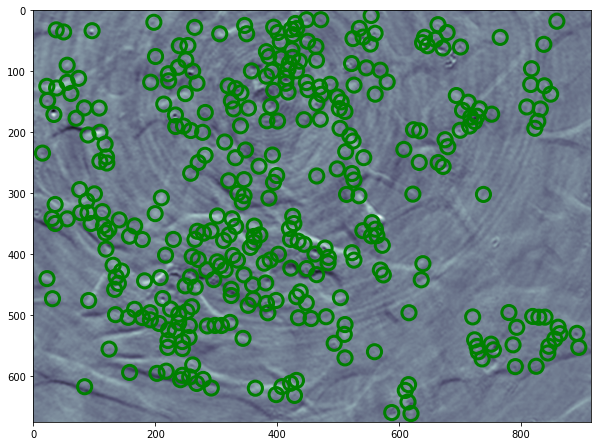

In [27]:
exp_data = experimental_data
dets = model.predict_and_detect(exp_data, alpha=0.05, beta=0.95, cutoff=0.9, mode="constant")

plt.figure(figsize=(10, 10))
plt.imshow(exp_data[0, ..., 1], cmap="bone")
plt.scatter(dets[0][:, 1], dets[0][:, 0], s=200, facecolor="none", linewidths=3, edgecolors="g")
plt.show()


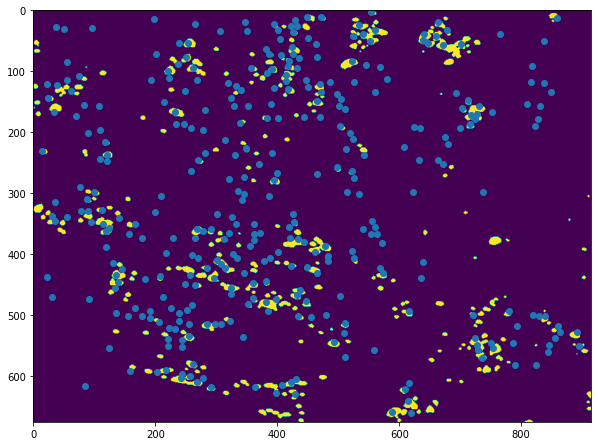

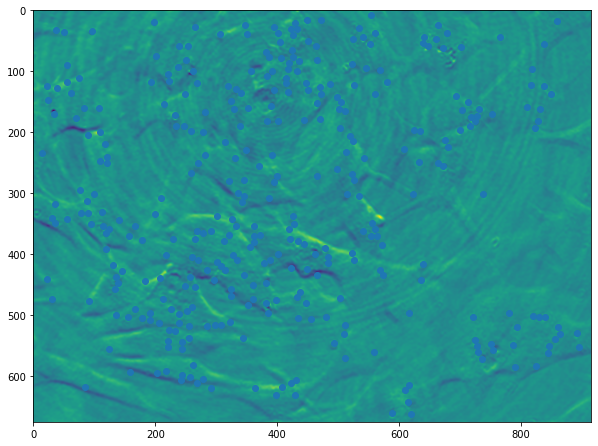

In [38]:
fluo = np.load(r"datasets/CellData/cell_fluo_mask.npy")


t = 0

plt.figure(figsize=(10, 10))
plt.imshow(fluo[t])
plt.scatter(dets[t][:,1]*1, dets[t][:, 0]*1.005 - 5)
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(exp_data[t,...,1])
plt.scatter(dets[t][:,1], dets[t][:, 0])
plt.show()
# plt.imshow(exp_data[1, ..., 1])
# plt.show()

In [39]:

traces = []
for idx in range(len(dets)):

    connections = []
    connected_observations = []
    # Trace doroplets
    for idy, trace in enumerate(traces):

        last_frame, *pos = trace[-1]
        if idx - last_frame > 4:
            continue

        for idz, new_pos in enumerate(dets[idx]):
            distance = np.sqrt(np.square(new_pos[:2] - pos[:2]).sum())
            
            if (
                distance < 5 and idz not in connected_observations
            ):
                connected_observations.append(idz)
                trace.append(np.array((idx, *new_pos)))

    detections = [p for i, p in enumerate(dets[idx]) if i not in connected_observations]

    # Initiate new traces
    for det in detections:
        traces.append([np.array((idx, *det))])

# traces = list(filter(lambda t: len(t) > , traces))

len(traces)

8469

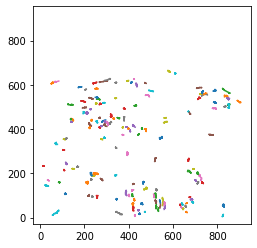

In [42]:
_traces = list(map(np.array, traces))
_traces = list(filter(lambda t: len(t) > 10, _traces))
for trace in _traces:
    plt.plot(trace[:, 2], trace[:, 1])
plt.axis("square")
plt.show()


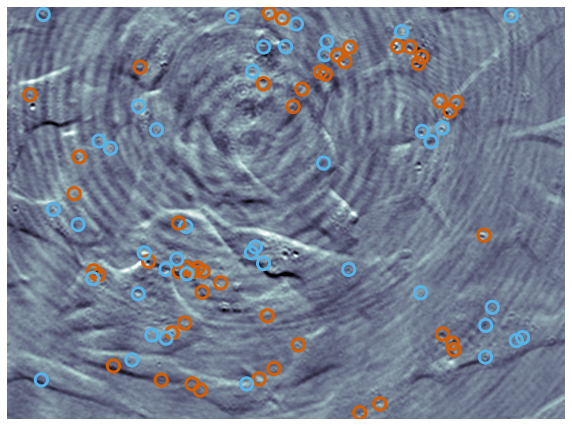

In [46]:
import seaborn
cl = []
for d in _traces:
    s = 0
    for _d in d:
        t, x, y =_d[0], _d[1]*1.005 - 5, _d[2]
        try:
            s += np.max(fluo[int(t), int(x)-0:int(x)+1, int(y)-0:int(y)+1])
        except ValueError:
            pass
    s /= len(d)
    if s > 0.5:
        cl.append(1)
    else:
        cl.append(0)

from IPython import display

c1 = seaborn.color_palette("colorblind")[3]
c2 = seaborn.color_palette("colorblind")[9]
for t, frame in enumerate(exp_data):
    if t % 10:
        continue
    plt.figure(figsize=(10, 10))
    plt.imshow(exp_data[t, :, :, 1], cmap="bone", vmin=-1, vmax=1)
    plt.axis("off")
    
    for j, (trace, c) in enumerate(zip(_traces, cl)):
        trace = np.array(trace)
        if np.any(trace[:, 0] == t):
            sub_trace = trace[(trace[:, 0] > t - 100) & (trace[:, 0] <= t)]
            
            plt.scatter(sub_trace[-1, 2], sub_trace[-1, 1], s=150, facecolor="none", linewidths=3, edgecolors=c1 if c else c2)
    display.clear_output(wait=True)
    plt.show()

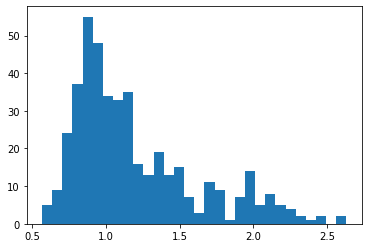

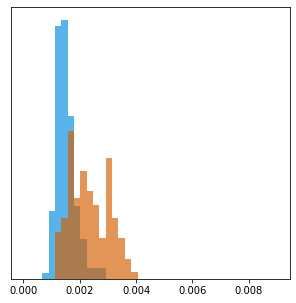

In [48]:
out = np.zeros((0,))
outa = np.zeros((0,))
outb = np.zeros((0,))
for d in _traces:

    s = 0
    for _d in d:
        t, x, y =_d[0], _d[1]*1.005 - 5, _d[2]
        try:
            s += np.max(fluo[int(t), int(x):int(x)+1, int(y):int(y)+1])
        except ValueError:
            pass
    s /= len(d)
    vals = dt.convolve(d[:, 3], np.ones((25,))/25)[::25]
    if s== 1:
        outa = np.concatenate((outa, vals), axis=0)
    elif s == 0:
        outb = np.concatenate((outb, vals), axis=0)

    out = np.concatenate((out, vals), axis=0)

plt.hist(np.exp(out), 30)
plt.show()

import seaborn

norm_factor = 0.228**3*(1.58 - 1.39) / np.median(np.exp(outa))

plt.figure(figsize=(5, 5))

plt.hist(np.exp(outb) * norm_factor, 40, range=(0, 4 * 0.228**3*(1.58 - 1.39)), density=True, alpha=1, color=seaborn.color_palette("colorblind")[9], edgecolor="none")
plt.hist(np.exp(outa) * norm_factor, 40, range=(0, 4 * 0.228**3*(1.58 - 1.39)), density=True, alpha=0.66, color=seaborn.color_palette("colorblind")[3], edgecolor="none")
plt.yticks([])